<a href="https://colab.research.google.com/github/Dzy00/CHL5230-datathon4/blob/main/Datathon_4_zhaoyu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploration

(91713, 186)
Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       ...
       'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object', length=186)
encounter_id                      0
patient_id                        0
hospital_id                       0
hospital_death                    0
age                            4228
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 186, dtype: int64


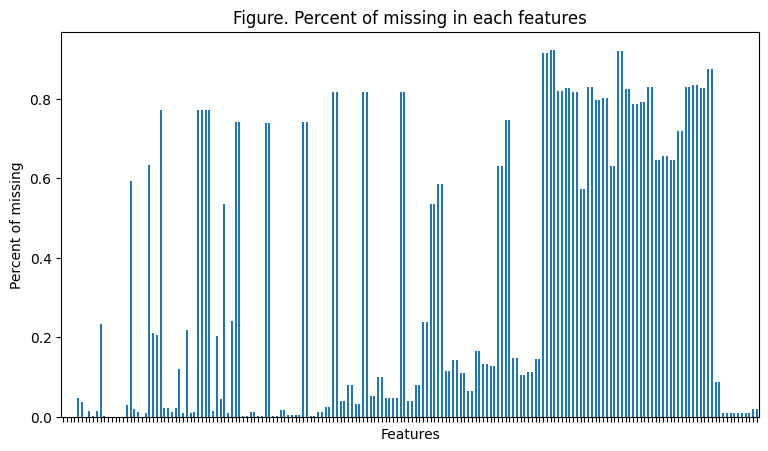

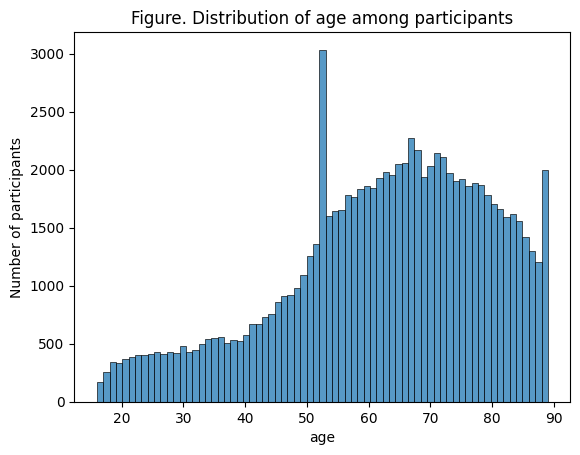

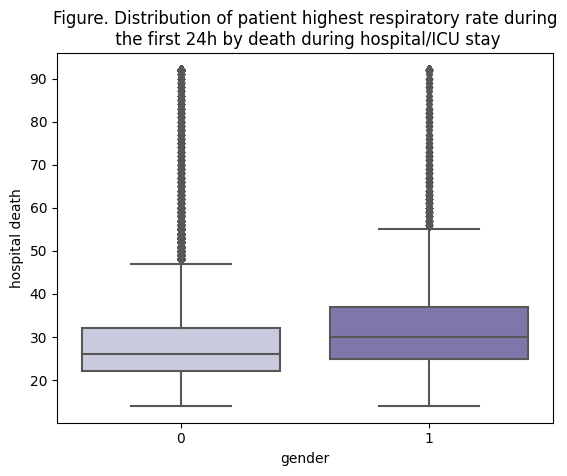

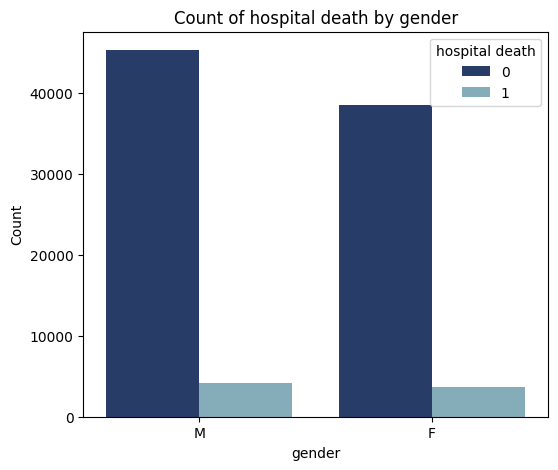

In [2]:
# CHL5230 Datathon 4

!pip install category_encoders

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# read dataset
data = pd.read_csv('datathon4.csv')
data.head()

# check dimension of the dataset
print(data.shape)

# list the columns of the dataframe
print(data.columns)

# summary statistics
description = data.describe()
description
#description.plot(kind='box', subplots=True, layout=(3, 5), figsize=(10, 5), color='#7569c9')
#plt.tight_layout()
#plt.show()

# check missing value
# no NA
print(data.isnull().sum())
data.isnull().sum().to_csv("missing count.csv")

# check some data types
data.apache_2_diagnosis.dtypes
data.apache_3j_diagnosis.dtypes

########################################################### visualization

plt.figure(figsize=(9,5))

# percent of missing
data.isnull().mean().plot.bar()
plt.ylabel('Percent of missing')
plt.xlabel('Features')
plt.title('Figure. Percent of missing in each features')
plt.tick_params(labelbottom=False)
plt.show()

# correlation matrix between variables
#mortal_Mcorr = mortal_df.corr()
#cmap = sns.diverging_palette(240, 10, as_cmap=True) # customerize cmap color
#sns.heatmap(mortal_Mcorr, annot=False, cmap=cmap)
#plt.show()

# Age
sns.histplot(data['age'])
plt.title('Figure. Distribution of age among participants')
plt.xlabel('age')
plt.ylabel('Number of participants')
plt.show()

# Gender
sns.boxplot( x=data['hospital_death'], y=data['d1_resprate_max'], palette="Purples")
plt.title('Figure. Distribution of patient highest respiratory rate during\n the first 24h by death during hospital/ICU stay')
plt.xlabel('gender')
plt.ylabel('hospital death')
plt.show()

# grouped bar chart
plt.figure(figsize=(6, 5))
sns.countplot(data=data, x='gender', hue='hospital_death', palette=['#1c3a73', '#7cb1c2'])
plt.xlabel('gender')
plt.ylabel('Count')
plt.title('Count of hospital death by gender')
plt.legend(title='hospital death')
plt.show()

# distribution of hospital death
import plotly.express as px
counts = data['hospital_death'].value_counts()
# Define color sequence
colors = ['#1c3a73', '#7cb1c2']
fig = px.pie(
    names=counts.index,
    values=counts.values,
    hole=0.5,  # size of the hole, 0.5 means 50%
    title='Distribution of Classes in hospital death Column',
    color_discrete_sequence=colors  # apply colors
)
fig.show()




# Missing data

In [4]:
########################################################## dealing with missing data
# cutoff 50%: remove features with >50% missing
data_clean = data.loc[:, data.isnull().mean() < .5]

data_clean.isnull().sum().to_csv("missing count cleaned.csv")

# Feature selection

(91713, 81)


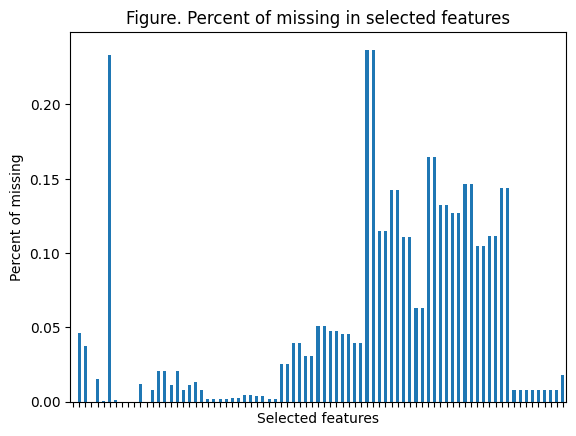

In [5]:
########################################################## feature selection
data_selected = data[['hospital_death',
                # demographic
                # drop 'readmission_status' (no variance)
                'age','bmi','elective_surgery','ethnicity','gender','hospital_admit_source','icu_admit_source',
                'icu_stay_type','icu_type','pre_icu_los_days',
                # apache
                # drop 'bun_apache', 'creatinine_apache', 'glucose_apache', 'hematocrit_apache', 'sodium_apache', 'wbc_apache' (>0.70 collinearity w/ respective lab features)
                # drop 'heart_rate_apache', 'temp_apache' (>0.70 collinearity w/ respective vitals features)
                # drop 'apache_2_diagnosis' (redundant w/ 'apache_3j_diagnosis')
                'apache_3j_diagnosis','apache_post_operative','arf_apache',
                'gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache','gcs_verbal_apache',
                'intubated_apache','map_apache','resprate_apache','ventilated_apache',
                # vitals
                # drop 'd1_diasbp_noninvasive_max','d1_diasbp_noninvasive_min','d1_mbp_noninvasive_max','d1_mbp_noninvasive_min','h1_diasbp_noninvasive_max',
                # 'h1_diasbp_noninvasive_min','h1_mbp_noninvasive_max','h1_mbp_noninvasive_min','h1_sysbp_noninvasive_max','h1_sysbp_noninvasive_min',
                'd1_diasbp_max','d1_diasbp_min','d1_heartrate_max','d1_heartrate_min','d1_mbp_max','d1_mbp_min',
                'd1_resprate_max','d1_resprate_min','d1_spo2_max','d1_spo2_min','d1_sysbp_max','d1_sysbp_min',
                'd1_temp_max','d1_temp_min','h1_diasbp_max','h1_diasbp_min','h1_heartrate_max','h1_heartrate_min',
                'h1_mbp_max','h1_mbp_min','h1_resprate_max','h1_resprate_min','h1_spo2_max','h1_spo2_min',
                'h1_sysbp_max','h1_sysbp_min','h1_temp_max','h1_temp_min',
                # labs
                'd1_bun_max','d1_bun_min','d1_calcium_max','d1_calcium_min','d1_creatinine_max','d1_creatinine_min',
                'd1_glucose_max','d1_glucose_min','d1_hco3_max','d1_hco3_min','d1_hemaglobin_max','d1_hemaglobin_min',
                'd1_hematocrit_max','d1_hematocrit_min','d1_platelets_max','d1_platelets_min','d1_potassium_max','d1_potassium_min',
                'd1_sodium_max','d1_sodium_min','d1_wbc_max','d1_wbc_min',
                # apache comorbidity
                # drop 'apache_4a_hospital_death_prob','apache_4a_icu_death_prob'
                'aids','cirrhosis','diabetes_mellitus','hepatic_failure','immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis',
                # apache grouping
                # drop 'apache_2_bodysystem' (redundant w/ 'apache_3j_bodysystem')
                'apache_3j_bodysystem']]
'''
data_selected = data_clean[['hospital_death',
                # demographic
                'age','bmi','elective_surgery','ethnicity', 'gender','hospital_admit_source','icu_admit_source',
                'icu_stay_type','icu_type','pre_icu_los_days','readmission_status',
                # apache
                'apache_2_diagnosis','apache_3j_diagnosis','apache_post_operative','arf_apache','bun_apache',
                'creatinine_apache','gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache','gcs_verbal_apache',
                'glucose_apache','heart_rate_apache','hematocrit_apache','intubated_apache','map_apache',
                'resprate_apache','sodium_apache','temp_apache','ventilated_apache','wbc_apache',
                # vitals
                # drop 'd1_diasbp_noninvasive_max','d1_diasbp_noninvasive_min','d1_mbp_noninvasive_max','d1_mbp_noninvasive_min','h1_diasbp_noninvasive_max',
                # 'h1_diasbp_noninvasive_min','h1_mbp_noninvasive_max','h1_mbp_noninvasive_min','h1_sysbp_noninvasive_max','h1_sysbp_noninvasive_min',
                'd1_diasbp_max','d1_diasbp_min','d1_heartrate_max','d1_heartrate_min','d1_mbp_max','d1_mbp_min',
                'd1_resprate_max','d1_resprate_min','d1_spo2_max','d1_spo2_min','d1_sysbp_max','d1_sysbp_min',
                'd1_temp_max','d1_temp_min','h1_diasbp_max','h1_diasbp_min','h1_heartrate_max','h1_heartrate_min',
                'h1_mbp_max','h1_mbp_min','h1_resprate_max','h1_resprate_min','h1_spo2_max','h1_spo2_min',
                'h1_sysbp_max','h1_sysbp_min','h1_temp_max','h1_temp_min',
                # labs
                'd1_bun_max','d1_bun_min','d1_calcium_max','d1_calcium_min','d1_creatinine_max','d1_creatinine_min',
                'd1_glucose_max','d1_glucose_min','d1_hco3_max','d1_hco3_min','d1_hemaglobin_max','d1_hemaglobin_min',
                'd1_hematocrit_max','d1_hematocrit_min','d1_platelets_max','d1_platelets_min','d1_potassium_max','d1_potassium_min',
                'd1_sodium_max','d1_sodium_min','d1_wbc_max','d1_wbc_min',
                # drop 'apache_4a_hospital_death_prob','apache_4a_icu_death_prob'
                # apache comorbidity
                'aids','cirrhosis','diabetes_mellitus','hepatic_failure','immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis',
                # apache grouping
                'apache_3j_bodysystem','apache_2_bodysystem']]
'''

print(data_selected.shape)

# export
data_selected.to_csv("data selected.csv")

# percent of missing plot
data_selected.isnull().mean().plot.bar()
plt.ylabel('Percent of missing')
plt.xlabel('Selected features')
plt.title('Figure. Percent of missing in selected features')
plt.tick_params(labelbottom=False)
plt.show()

# Define the column that will be used as the target for modeling or analysis
target_column = 'hospital_death'

# identify categorical variables
categorical_columns = ['elective_surgery','ethnicity', 'gender','hospital_admit_source','icu_admit_source',
                       'icu_stay_type','icu_type','readmission_status','apache_2_diagnosis','apache_3j_diagnosis',
                       'apache_post_operative','arf_apache','gcs_unable_apache','intubated_apache','ventilated_apache',
                       'aids','cirrhosis','diabetes_mellitus','hepatic_failure','immunosuppression','leukemia','lymphoma',
                       'solid_tumor_with_metastasis','apache_3j_bodysystem','apache_2_bodysystem']

# numerical variables
numerical_columns = [c for c in data_selected.columns if c not in categorical_columns and c != target_column]

# drop rows with NA in age, gender, ethnicity,
# data_selected.dropna(subset=['age','gender','ethnicity'], how='any')

# imputation
# trf1 = ColumnTransformer(transformers =[
#	('cat', SimpleImputer(strategy ='most_frequent'), categorical_columns),
#	('num', SimpleImputer(strategy ='median'), numerical_columns),
# ], remainder ='passthrough')

# PCA
all rows with missing values in the remaining 91 features are dropped for this analysis

(37451, 81)
[9.99733287e-01 3.53872407e-05 2.06755583e-05 1.75541208e-05
 1.51525886e-05 1.38414140e-05 1.02501010e-05 9.85027384e-06
 9.11656175e-06 8.16905613e-06 7.54629963e-06 7.21274058e-06
 6.99003188e-06 6.34720296e-06 5.78091440e-06 5.27014498e-06
 5.18981359e-06 4.77869174e-06 4.39838233e-06 4.30980299e-06
 4.23457071e-06 3.92042390e-06 3.57007046e-06 3.32395914e-06
 2.90191736e-06 2.81436537e-06 2.78509198e-06 2.55234413e-06
 2.43552575e-06 2.21175532e-06 2.18492219e-06 2.06009496e-06
 1.88894210e-06 1.76574943e-06 1.68777315e-06 1.55688356e-06
 1.45450834e-06 1.41072922e-06 1.36897862e-06 1.22223281e-06
 1.16202592e-06 1.13070015e-06 1.07802305e-06 1.01330841e-06
 8.76949235e-07 8.11711777e-07 7.67684387e-07 7.45443888e-07
 7.26800850e-07 6.94039376e-07 6.03085232e-07 5.96194545e-07
 5.87080623e-07 5.62770137e-07 5.28214995e-07 5.22559737e-07
 5.07209732e-07 4.58467633e-07 4.38470798e-07 4.14533118e-07
 3.91658828e-07 3.88614782e-07 3.69893266e-07 3.31616515e-07
 3.15411368e

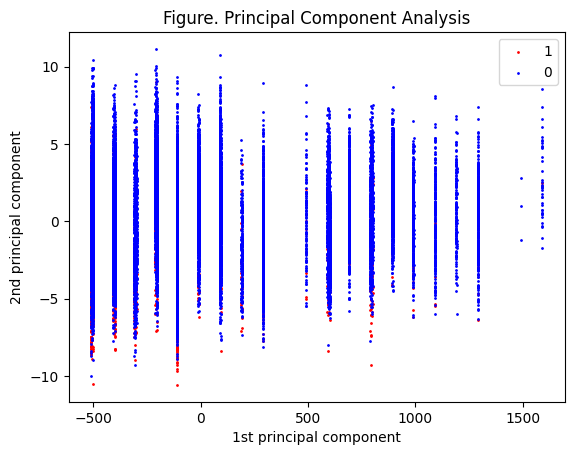

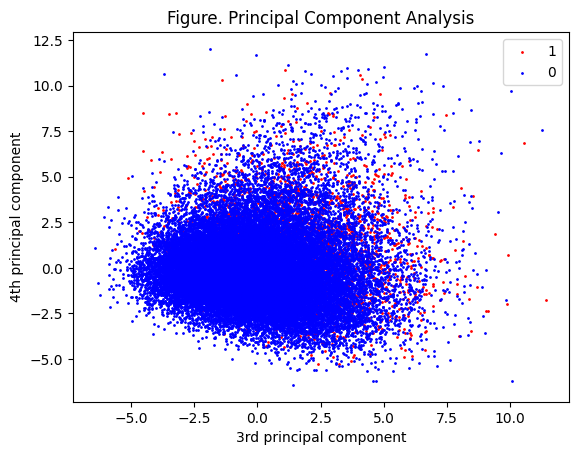

In [7]:
########################################################## PCA
# reference: https://towardsdatascience.com/one-hot-encoding-standardization-pca-data-preparation-steps-for-segmentation-in-python-24d07671cf0b
# https://www.datacamp.com/tutorial/principal-component-analysis-in-python

from sklearn.decomposition import PCA

# drop rows with NA in any remaining columns
data_noNA = data_selected.dropna()
print(data_noNA.shape)

data_noNA.to_csv("data_noNA.csv")

# rename index
data_noNA.set_index(np.arange(0, 37451), inplace=True)

# standardize numerical variables
scaler = StandardScaler()
data_noNA[numerical_columns] = scaler.fit_transform(data_noNA[numerical_columns])

# encode categorical variables
data_noNA_encoded = pd.get_dummies(data_noNA.drop('hospital_death', axis=1))

# apply PCA
pca = PCA()
pca_data = pca.fit_transform(data_noNA_encoded)

# restul: explained variance by each PC
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

# loadings
loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_),index=data_noNA_encoded.columns)
PC1_loadings = loadings[0] # PC1 loadings
PC1_loadings.to_csv("PC1 loadings.csv")

# extract PC
pc = pd.DataFrame(data = pca_data)

# check number of components needed to retain 80% variance
for i in range(1,pc.shape[1]):
    sum_var = sum(pca.explained_variance_ratio_[0:i])
    if sum_var > 0.8:
        print("the first {} of the principal components explained {}% of total variance".format(i, sum_var*100))
        break

# result: the 1st component explained 97.58% of the total variance

# plot
plt.figure()
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')
plt.title('Figure. Principal Component Analysis')
targets = [1, 0]
colors = ['red', 'blue']
for target, color in zip(targets,colors):
    index = data_noNA['hospital_death'] == target
    plt.scatter(pc.loc[index, 0],pc.loc[index, 1], c = color, s = 1)

plt.legend(targets)
plt.show()

# plot 2
plt.figure()
plt.xlabel('3rd principal component')
plt.ylabel('4th principal component')
plt.title('Figure. Principal Component Analysis')
for target, color in zip(targets,colors):
    index = data_noNA['hospital_death'] == target
    plt.scatter(pc.loc[index,2],pc.loc[index, 3], c = color, s = 1)

plt.legend(targets)
plt.show()



# Decision Tree


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.79      0.86     25161
           1       0.21      0.62      0.32      2353

    accuracy                           0.77     27514
   macro avg       0.59      0.70      0.59     27514
weighted avg       0.89      0.77      0.82     27514



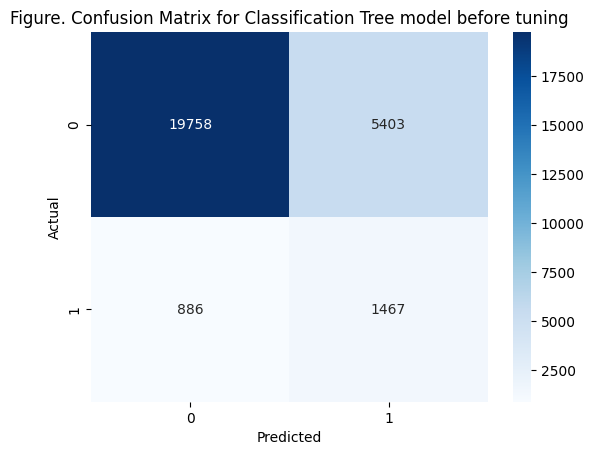

0.7833455349771803
0.7706622083303045

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.78      0.86     25161
           1       0.23      0.70      0.34      2353

    accuracy                           0.77     27514
   macro avg       0.60      0.74      0.60     27514
weighted avg       0.90      0.77      0.82     27514



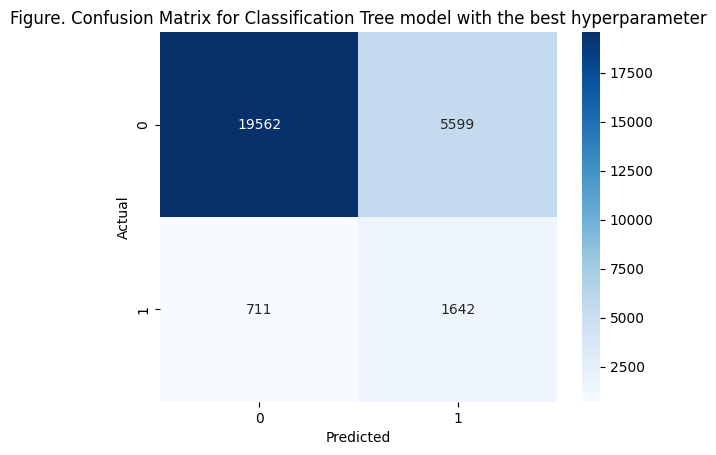

In [11]:
!pip install category_encoders

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings('ignore')

# read dataset
data_selected = pd.read_csv('data selected.csv')

# define the column that will be used as the target for modeling or analysis
target_column = 'hospital_death'

# identify categorical variables
#categorical_columns = ['elective_surgery','ethnicity', 'gender','hospital_admit_source','icu_admit_source',
#                       'icu_stay_type','icu_type','readmission_status','apache_2_diagnosis','apache_3j_diagnosis',
#                       'apache_post_operative','arf_apache','gcs_unable_apache','intubated_apache','ventilated_apache',
#                       'aids','cirrhosis','diabetes_mellitus','hepatic_failure','immunosuppression','leukemia','lymphoma',
#                       'solid_tumor_with_metastasis','apache_3j_bodysystem','apache_2_bodysystem']

categorical_columns = ['ethnicity', 'gender','hospital_admit_source','icu_admit_source',
                       'icu_stay_type','icu_type','apache_3j_bodysystem']


# numerical variables
numerical_columns = [c for c in data_selected.columns if c not in categorical_columns and c != target_column]

# probabilistic prediction of in ICU mortality:
# apache_4a_icu_death_prob, apache_4a_hospital_death_prob

########################################################## decision tree model
# pipeline reference: https://www.kaggle.com/code/datascientistsohail/pipelines-using-simpleimputer-and-onehotencoder

# Splitting the data into 70% training and 30% testing
train = data_selected.sample(frac=0.7, random_state=11)
test = data_selected.drop(train.index)

# features
X_train = train.drop('hospital_death', axis = 1)
# outcome
y_train = train['hospital_death']

# imputate numerical columns with median
num_transformer = SimpleImputer(strategy = 'median')

# impute categorical columns with the most frequent value
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('one_hot_encoder', OneHotEncoder())
    ])

# initialize a column transformer that handels imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_columns),
        ('cat', cat_transformer, categorical_columns)
        ],
    remainder='passthrough')

# Initializing a column transformer that will handle categorical data encoding
#ct = ColumnTransformer([('one_hot_encoder', OneHotEncoder(), [c for c in categorical_columns if c != 'ethnicity']),
#                        ('target_encoder', TargetEncoder(), ['ethnicity'])],
#                       remainder='passthrough')

# Initializing a Decision Tree classifier
dt = tree.DecisionTreeClassifier(criterion='entropy',class_weight='balanced')

# build pipeline for preprocessing and model fitting
my_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    #('tomek', TomekLinks()),
    ('under_sample', RandomUnderSampler(sampling_strategy=0.5)),
    ('up_sample', SMOTE(sampling_strategy=1)),
    ('DT', dt)
])

# Training the model on the training data
model = my_pipe.fit(X_train, y_train)

# Predicting and evaluating the model's performance on the training data
Y_pred = model.predict(X_train)
accuracy_score(y_train, Y_pred)

# Predicting and evaluating the model's performance on the test data
Y_pred = model.predict(test.drop('hospital_death', axis = 1))
accuracy_score(test['hospital_death'], Y_pred)

# confusion matrix on test data
Y_test = test['hospital_death']
conf_matrix_Tree = confusion_matrix(Y_test, Y_pred)
class_report_Tree = classification_report(Y_test, Y_pred)

print("\nClassification Report:")
print(class_report_Tree)

sns.heatmap(conf_matrix_Tree, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Figure. Confusion Matrix for Classification Tree model before tuning')
plt.show()


##### hyperparameter tuning with grid search
# Define the hyperparameter values that should be tested
param_dist = {
    "DT__max_depth" : [5, 10, 15, 20 ,25, 30, 35],
    "DT__min_samples_leaf" : [5, 10, 15, 20 ,25],
    "DT__splitter" : ['best', 'random'],
    "DT__max_features" : ['sqrt', 'log2']
}

# Setting up Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5)

# Initialize Grid Search with the model and the hyperparameters to search
random_search = GridSearchCV(
    model, param_grid=param_dist, cv=skf
)

# Train Grid Search on the training data
random_search.fit(X_train, y_train)

# Extract results into a DataFrame
results = pd.DataFrame(random_search.cv_results_)

# Display the set of parameters that achieved the best score
results[results['rank_test_score'] == 1]

# Retrieve the best hyperparameters after Grid Search
random_search.best_params_


##### Refitting the Model with Optimal Hyperparameters
# Update the model's hyperparameters to the best found during Grid Search
model = model.set_params(**random_search.best_params_)

# Refit the model using the training data
model = model.fit(X_train, y_train)

# Make predictions on the training set and compute the accuracy
Y_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, Y_pred)
print(train_accuracy)

# Make predictions on the test set and compute the accuracy
Y_test = test['hospital_death']
Y_pred = model.predict(test.drop('hospital_death', axis = 1))
test_accuracy = accuracy_score(Y_test, Y_pred)
print(test_accuracy)

# confusion matrix on test data
conf_matrix_Tree = confusion_matrix(Y_test, Y_pred)
class_report_Tree = classification_report(Y_test, Y_pred)

print("\nClassification Report:")
print(class_report_Tree)

sns.heatmap(conf_matrix_Tree, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Figure. Confusion Matrix for Classification Tree model with the best hyperparameter')
plt.show()




# Random Forest


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     25161
           1       0.33      0.72      0.45      2353

    accuracy                           0.85     27514
   macro avg       0.65      0.79      0.68     27514
weighted avg       0.92      0.85      0.87     27514



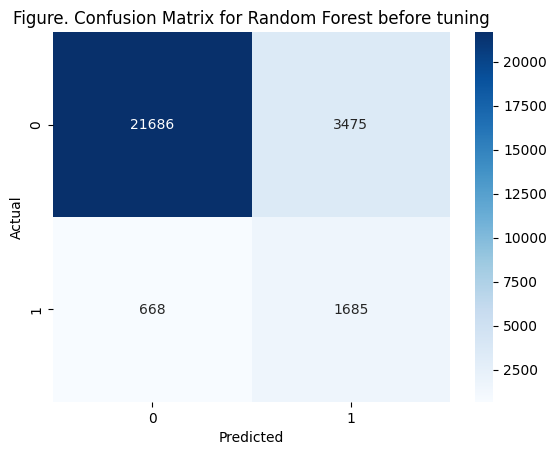

0.8573498029564324
0.8429890237697172

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     25161
           1       0.32      0.73      0.44      2353

    accuracy                           0.84     27514
   macro avg       0.64      0.79      0.68     27514
weighted avg       0.91      0.84      0.87     27514



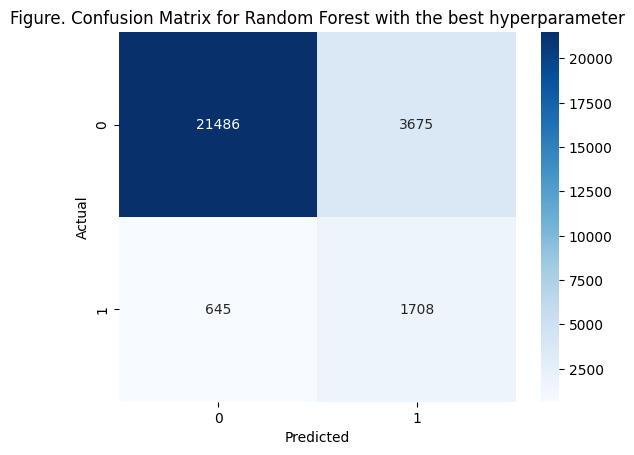

In [15]:
# read dataset
data_selected = pd.read_csv('data selected.csv')

# define the column that will be used as the target for modeling or analysis
target_column = 'hospital_death'

# identify categorical variables
#categorical_columns = ['elective_surgery','ethnicity', 'gender','hospital_admit_source','icu_admit_source',
#                       'icu_stay_type','icu_type','readmission_status','apache_2_diagnosis','apache_3j_diagnosis',
#                       'apache_post_operative','arf_apache','gcs_unable_apache','intubated_apache','ventilated_apache',
#                       'aids','cirrhosis','diabetes_mellitus','hepatic_failure','immunosuppression','leukemia','lymphoma',
#                       'solid_tumor_with_metastasis','apache_3j_bodysystem','apache_2_bodysystem']

categorical_columns = ['ethnicity', 'gender','hospital_admit_source','icu_admit_source',
                       'icu_stay_type','icu_type','apache_3j_bodysystem']

# numerical variables
numerical_columns = [c for c in data_selected.columns if c not in categorical_columns and c != target_column]

# probabilistic prediction of in ICU mortality:
# apache_4a_icu_death_prob, apache_4a_hospital_death_prob

########################################################## random forest model
# pipeline reference: https://www.kaggle.com/code/datascientistsohail/pipelines-using-simpleimputer-and-onehotencoder

# Splitting the data into 70% training and 30% testing
train = data_selected.sample(frac=0.7, random_state=11)
test = data_selected.drop(train.index)

# features
X_train = train.drop('hospital_death', axis = 1)
# outcome
y_train = train['hospital_death']

# imputate numerical columns with median
num_transformer = SimpleImputer(strategy = 'median')

# impute categorical columns with the most frequent value
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('one_hot_encoder', OneHotEncoder())
    ])

# initialize a column transformer that handels imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_columns),
        ('cat', cat_transformer, categorical_columns)
        ],
    remainder='passthrough')

# Initializing a column transformer that will handle categorical data encoding
#ct = ColumnTransformer([('one_hot_encoder', OneHotEncoder(), [c for c in categorical_columns if c != 'ethnicity']),
#                        ('target_encoder', TargetEncoder(), ['ethnicity'])],
#                       remainder='passthrough')

# Initialize a Random Forest classifier
random_forest = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', oob_score=True)

# build pipeline for preprocessing and model fitting
my_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    #('tomek', TomekLinks()),
    ('under_sample', RandomUnderSampler(sampling_strategy=0.5)),
    ('up_sample', SMOTE(sampling_strategy=1)),
    ('random_forest', random_forest)
])

# Display the pipeline architecture
my_pipe

# Training the model on the training data
model = my_pipe.fit(X_train, y_train)

# Predicting and evaluating the model's performance on the training data
Y_pred = model.predict(X_train)
accuracy_score(y_train, Y_pred)

# Predicting and evaluating the model's performance on the test data
Y_pred = model.predict(test.drop('hospital_death', axis = 1))
accuracy_score(test['hospital_death'], Y_pred)

# confusion matrix on test data
Y_test = test['hospital_death']
conf_matrix_forest = confusion_matrix(Y_test, Y_pred)
class_report_forest = classification_report(Y_test, Y_pred)

print("\nClassification Report:")
print(class_report_forest)

sns.heatmap(conf_matrix_forest, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Figure. Confusion Matrix for Random Forest before tuning')
plt.show()


##### hyperparameter tuning with grid search
# Setting hyperparameters for Random Forest for the Grid Search.
param_dist = {
    "random_forest__n_estimators" : [200],
    "random_forest__max_depth" : [5, 10, 15],
    "random_forest__min_samples_leaf" : [15, 20 ,25],
    "random_forest__max_features" : ['sqrt']
}

# Initializing stratified K-fold cross-validation. This ensures each fold has the same proportion of target labels as the whole dataset.
skf = StratifiedKFold(n_splits=5)

# Setting up GridSearchCV to search through the parameter space.
# It will evaluate the model for each combination of hyperparameters provided using stratified K-fold cross-validation.
random_search = GridSearchCV(
    model, param_grid=param_dist, cv=skf
)

# Train Grid Search on the training data
random_search.fit(X_train, y_train)

# Extract results into a DataFrame
results = pd.DataFrame(random_search.cv_results_)

# Display the set of parameters that achieved the best score
results[results['rank_test_score'] == 1]

# Retrieve the best hyperparameters after Grid Search
random_search.best_params_


##### Refitting the Model with Optimal Hyperparameters
# Update the model's hyperparameters to the best found during Grid Search
model = model.set_params(**random_search.best_params_)

# Refit the model using the training data
model = model.fit(X_train, y_train)

# Make predictions on the training set and compute the accuracy
Y_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, Y_pred)
print(train_accuracy)

# Make predictions on the test set and compute the accuracy
Y_test = test['hospital_death']
Y_pred = model.predict(test.drop('hospital_death', axis = 1))
test_accuracy = accuracy_score(Y_test, Y_pred)
print(test_accuracy)

# confusion matrix on test data
conf_matrix_forest = confusion_matrix(Y_test, Y_pred)
class_report_forest = classification_report(Y_test, Y_pred)

print("\nClassification Report:")
print(class_report_forest)

sns.heatmap(conf_matrix_forest, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Figure. Confusion Matrix for Random Forest with the best hyperparameter')
plt.show()



# XGBoost Classifier


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92     25161
           1       0.34      0.69      0.45      2353

    accuracy                           0.86     27514
   macro avg       0.65      0.78      0.68     27514
weighted avg       0.91      0.86      0.88     27514



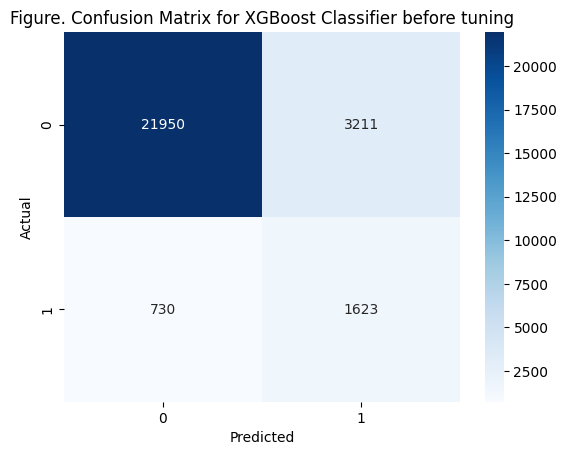

0.8904032773096154
0.870029803009377

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     25161
           1       0.37      0.71      0.48      2353

    accuracy                           0.87     27514
   macro avg       0.67      0.80      0.70     27514
weighted avg       0.92      0.87      0.89     27514



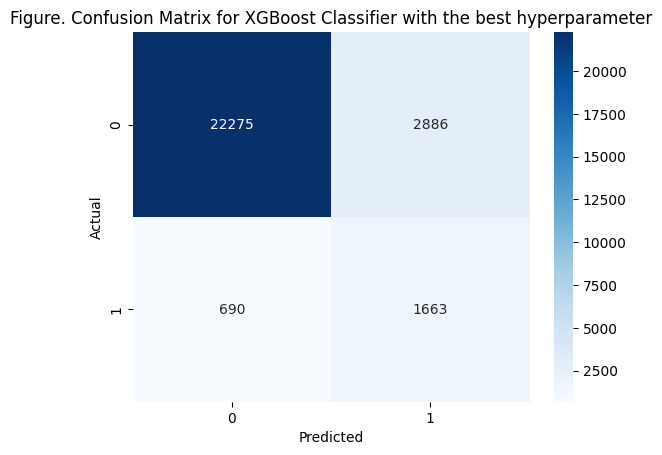

In [17]:
# read dataset
data_selected = pd.read_csv('data selected.csv')

# define the column that will be used as the target for modeling or analysis
target_column = 'hospital_death'

# identify categorical variables
#categorical_columns = ['elective_surgery','ethnicity', 'gender','hospital_admit_source','icu_admit_source',
#                       'icu_stay_type','icu_type','readmission_status','apache_2_diagnosis','apache_3j_diagnosis',
#                       'apache_post_operative','arf_apache','gcs_unable_apache','intubated_apache','ventilated_apache',
#                       'aids','cirrhosis','diabetes_mellitus','hepatic_failure','immunosuppression','leukemia','lymphoma',
#                       'solid_tumor_with_metastasis','apache_3j_bodysystem','apache_2_bodysystem']

categorical_columns = ['ethnicity', 'gender','hospital_admit_source','icu_admit_source',
                       'icu_stay_type','icu_type','apache_3j_bodysystem']

# numerical variables
numerical_columns = [c for c in data_selected.columns if c not in categorical_columns and c != target_column]

# probabilistic prediction of in ICU mortality:
# apache_4a_icu_death_prob, apache_4a_hospital_death_prob

########################################################## XGBoost Classifier
# pipeline reference: https://www.kaggle.com/code/datascientistsohail/pipelines-using-simpleimputer-and-onehotencoder

# Splitting the data into 70% training and 30% testing
train = data_selected.sample(frac=0.7, random_state=11)
test = data_selected.drop(train.index)

# features
X_train = train.drop('hospital_death', axis = 1)
# outcome
y_train = train['hospital_death']

# imputate numerical columns with median
num_transformer = SimpleImputer(strategy = 'median')

# impute categorical columns with the most frequent value
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('one_hot_encoder', OneHotEncoder())
    ])

# initialize a column transformer that handels imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_columns),
        ('cat', cat_transformer, categorical_columns)
        ],
    remainder='passthrough')

# Initializing a column transformer that will handle categorical data encoding
#ct = ColumnTransformer([('one_hot_encoder', OneHotEncoder(), [c for c in categorical_columns if c != 'ethnicity']),
#                        ('target_encoder', TargetEncoder(), ['ethnicity'])],
#                       remainder='passthrough')

# Initializing the Gradient Boosting Classifier with specified parameters
xg_boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

# build pipeline for preprocessing and model fitting
my_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    #('tomek', TomekLinks()),
    ('under_sample', RandomUnderSampler(sampling_strategy=0.5)),
    ('up_sample', SMOTE(sampling_strategy=1)),
    ('xg_boost', xg_boost)
])

# Training the model on the training data
model = my_pipe.fit(X_train, y_train)

# Predicting and evaluating the model's performance on the training data
Y_pred = model.predict(X_train)
accuracy_score(y_train, Y_pred)

# Predicting and evaluating the model's performance on the test data
Y_pred = model.predict(test.drop('hospital_death', axis = 1))
accuracy_score(test['hospital_death'], Y_pred)

# confusion matrix on test data
Y_test = test['hospital_death']
conf_matrix_xg = confusion_matrix(Y_test, Y_pred)
class_report_xg = classification_report(Y_test, Y_pred)

print("\nClassification Report:")
print(class_report_xg)

sns.heatmap(conf_matrix_xg, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Figure. Confusion Matrix for XGBoost Classifier before tuning')
plt.show()


##### hyperparameter tuning with grid search
# Defining the hyperparameters to be tuned using GridSearchCV
param_dist = {
    "xg_boost__n_estimators" : [100, 200],
    "xg_boost__max_depth" : [1, 5],
    "xg_boost__min_samples_leaf" : [25],
    "xg_boost__learning_rate" : [.1,  .2]
}

# Using StratifiedKFold for cross-validation, ensuring each fold has the same proportion of observations with each target value
skf = StratifiedKFold(n_splits=5)

# Setting up the GridSearchCV to find the best hyperparameters for the Gradient Boosting model
random_search = GridSearchCV(
    model, param_grid=param_dist, cv=skf
)

# Train Grid Search on the training data
random_search.fit(X_train, y_train)

# Storing and displaying the results of the grid search
results = pd.DataFrame(random_search.cv_results_)
results[results['rank_test_score'] == 1]

# Retrieve the best hyperparameters after Grid Search
random_search.best_params_


##### Refitting the Model with Optimal Hyperparameters
# Update the model's hyperparameters to the best found during Grid Search
model = model.set_params(**random_search.best_params_)

# Refit the model using the training data
model = model.fit(X_train, y_train)

# Make predictions on the training set and compute the accuracy
Y_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, Y_pred)
print(train_accuracy)

# Make predictions on the test set and compute the accuracy
Y_test = test['hospital_death']
Y_pred = model.predict(test.drop('hospital_death', axis = 1))
test_accuracy = accuracy_score(Y_test, Y_pred)
print(test_accuracy)

# confusion matrix on test data
conf_matrix_xg = confusion_matrix(Y_test, Y_pred)
class_report_xg = classification_report(Y_test, Y_pred)

print("\nClassification Report:")
print(class_report_xg)

sns.heatmap(conf_matrix_xg, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Figure. Confusion Matrix for XGBoost Classifier with the best hyperparameter')
plt.show()
